In [1]:
# importing modules and libraries

import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.layers import Input, InputLayer, Conv2D, MaxPooling2D, Flatten, ELU, Dense, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.optimizers import Nadam

2024-06-09 09:25:21.952243: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 09:25:21.952345: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 09:25:22.093658: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 39997 files belonging to 5 classes.


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


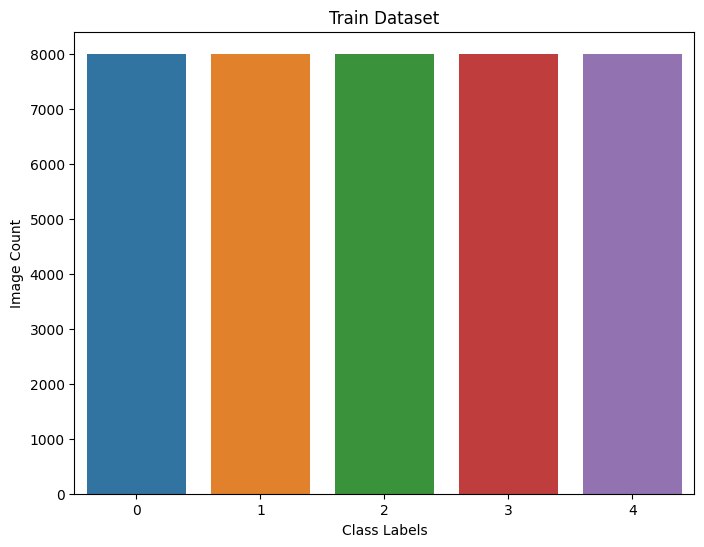

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Loading train and val datasets
train_dataset = keras.utils.image_dataset_from_directory(
    "/kaggle/input/pathogen-dataset/pathogen",
    image_size=(4, 4),
    batch_size=32
)

# Collecting class labels
train_labels = []
for _, labels in train_dataset:
    train_labels.extend(labels.numpy())

# Counting occurrences of each label
train_label_counts = Counter(train_labels)

# Plotting the counts
plt.figure(figsize=(8, 6))

sns.barplot(x=list(train_label_counts.keys()), y=list(train_label_counts.values()))
plt.title('Train Dataset')
plt.xlabel('Class Labels')
plt.ylabel('Image Count')
plt.show()

In [3]:
import gc # calling garbage collector to reduce memory utilization

del train_dataset

gc.collect()

4061

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Load the dataset
dataset = keras.utils.image_dataset_from_directory(
    "/kaggle/input/pathogen-dataset/pathogen",
    image_size=(192, 192),
    batch_size=32
)

# Normalize the dataset
normalization_layer = keras.layers.Rescaling(1./255)
normalized_dataset = dataset.map(lambda x, y: (normalization_layer(x), y))

# Initialize lists to store images and labels by class
class_images = [[] for _ in range(5)]

# Group images by class
for images, labels in normalized_dataset:
    for image, label in zip(images, labels):
        class_images[label.numpy()].append(image.numpy())

# Sample 1000 images from each class
sampled_images = []
sampled_labels = []
for class_index, images in enumerate(class_images):
    sampled_indices = np.random.choice(len(images), 1000, replace=False)
    for index in sampled_indices:
        sampled_images.append(images[index])
        sampled_labels.append(class_index)

# Convert lists to arrays
sampled_images = np.array(sampled_images)
sampled_labels = np.array(sampled_labels)

# Convert labels to probability distributions
sampled_labels = keras.utils.to_categorical(sampled_labels, 5)

# Verify the shapes of the arrays
print(f'Images shape: {sampled_images.shape}')
print(f'Labels shape: {sampled_labels.shape}')

Found 39997 files belonging to 5 classes.
Images shape: (5000, 192, 192, 3)
Labels shape: (5000, 5)


In [3]:
import gc # calling garbage collector to reduce memory utilization

del normalized_dataset
del dataset

gc.collect()

264

In [4]:
# Split the data
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp = train_test_split(sampled_images, sampled_labels, test_size=0.3,random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)

print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)

x_train: (3500, 192, 192, 3)
y_train: (3500, 5)
x_test: (750, 192, 192, 3)
y_test: (750, 5)
x_val: (750, 192, 192, 3)
y_val: (750, 5)


In [5]:
from keras import mixed_precision # changing precision policies
mixed_precision.set_global_policy('mixed_float16')

In [6]:
import tensorflow as tf

tf.config.optimizer.set_jit(True) # setting optimizer to reduce model computation by optimizing graph-computations

### VGG16

In [7]:
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau

# Loading model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(192, 192, 3))
feature_extractor = Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('block4_pool').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

model.summary() # printing summary of model

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 192, 192, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 192, 192, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 192, 192, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 96, 96, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 96, 96, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 96, 96, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 48, 48, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 48, 48, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 48, 48, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 24, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 24, 24, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 24, 24, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,165,701 (31.15 MB)

 Trainable params: 530,437 (2.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=40,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
 5/88 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.3298 - loss: 2.1471

I0000 00:00:1717922626.856881     465 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.6196 - loss: 1.1921
Epoch 1: val_accuracy improved from -inf to 0.89333, saving model to model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 47s 316ms/step - accuracy: 0.6213 - loss: 1.1865 - val_accuracy: 0.8933 - val_loss: 0.3248 - learning_rate: 0.0010
Epoch 2/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9025 - loss: 0.2993
Epoch 2: val_accuracy improved from 0.89333 to 0.93067, saving model to model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9026 - loss: 0.2990 - val_accuracy: 0.9307 - val_loss: 0.2464 - learning_rate: 0.0010
Epoch 3/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9400 - loss: 0.1993
Epoch 3: val_accuracy did not improve from 0.93067
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9399 - loss: 0.1993 - val_accuracy: 0.9240 - val_loss: 0.2199 - learning_rate: 0.0010
Epoch 4/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9417 - loss: 0.1752
Epoch 4: val_accuracy improved f

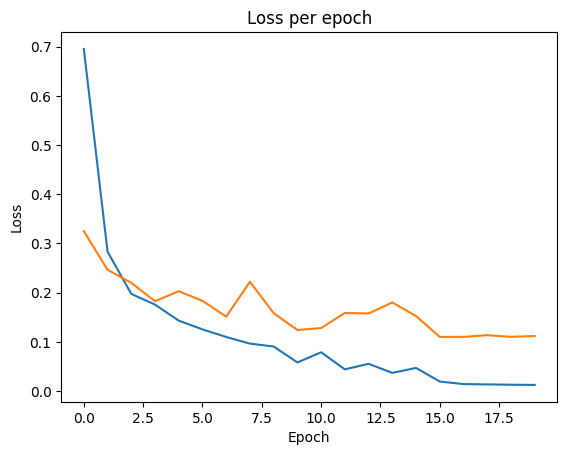

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

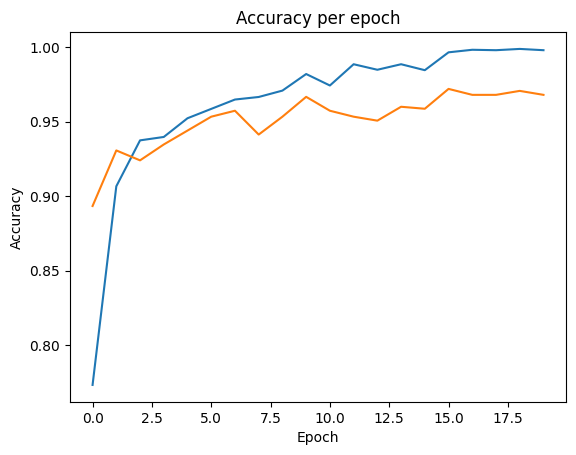

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### NASNetMobile

In [7]:
from keras.applications import NASNetMobile
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading NASNetMobile model
nasnetmobile_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(192, 192, 3))

# Freezing convolutional layers
for layer in nasnetmobile_model.layers:
    layer.trainable = False

# Adding dense layers on top
x = nasnetmobile_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

# Binding model
model = Model(inputs=nasnetmobile_model.input, outputs=output)

# Setting callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 192, 192,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv1 (Conv2D) │ (None, 95, 95,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn1            │ (None, 95, 95,    │        128 │ stem_conv1[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 95, 95,    │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_conv_1_s… │ (None, 95, 95,    │        352 │ activation[0][0]  │
│ (Conv2D)            │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_bn_1_ste… │ (None, 95, 95,    │         44 │ reduction_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 95, 95,    │          0 │ reduction_bn_1_s… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 95, 95,    │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 99, 99,    │          0 │ activation_1[0][… │
│ (ZeroPadding2D)     │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 101, 101,  │          0 │ activation_3[0][… │
│ (ZeroPadding2D)     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 48, 48,    │        396 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 48, 48,    │      1,920 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 48, 48,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 48, 48,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 48, 48,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 48, 48,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_2_r… │ (None, 48, 48,    │        396 │ activation_2[0][

 Total params: 5,357,209 (20.44 MB)

 Trainable params: 1,087,493 (4.15 MB)

 Non-trainable params: 4,269,716 (16.29 MB)

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=40,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
 2/88 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.1500 - loss: 2.1793    

I0000 00:00:1717923239.359729    1124 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.6164 - loss: 1.1031
Epoch 1: val_accuracy improved from -inf to 0.92533, saving model to model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 96s 599ms/step - accuracy: 0.6182 - loss: 1.0978 - val_accuracy: 0.9253 - val_loss: 0.2378 - learning_rate: 0.0010
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9378 - loss: 0.1953
Epoch 2: val_accuracy did not improve from 0.92533
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9377 - loss: 0.1953 - val_accuracy: 0.9213 - val_loss: 0.2102 - learning_rate: 0.0010
Epoch 3/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9541 - loss: 0.1441
Epoch 3: val_accuracy did not improve from 0.92533
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9540 - loss: 0.1442 - val_accuracy: 0.9093 - val_loss: 0.2578 - learning_rate: 0.0010
Epoch 4/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9695 - loss: 0.0902
Epoch 4: val_accuracy improved from 0.92533 to 0.93867, saving mo

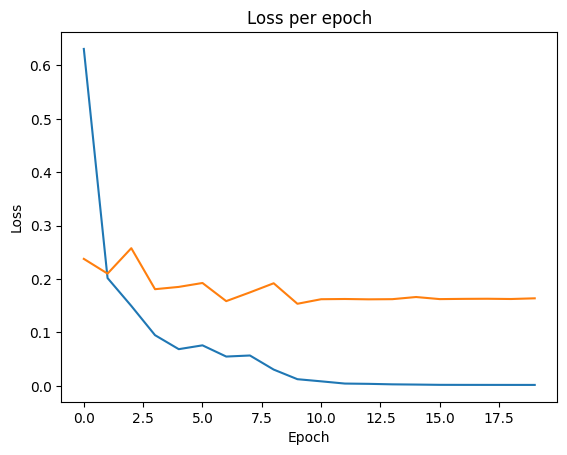

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

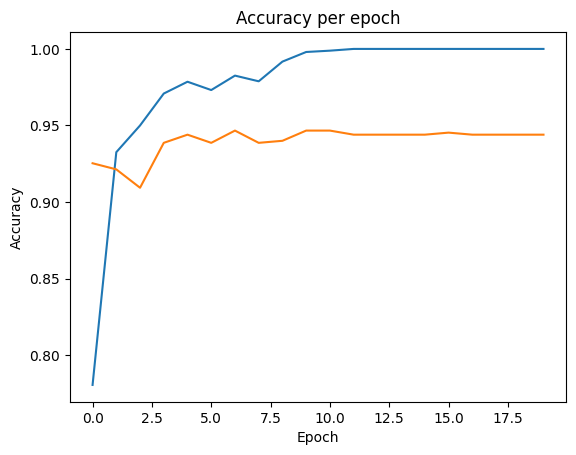

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### DenseNet121

In [7]:
from keras.applications import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading model
densenet121_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(192, 192, 3))
feature_extractor = Model(inputs=densenet121_model.input, outputs=densenet121_model.get_layer('conv5_block6_concat').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False
    
# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 192, 192,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 198, 198,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 96, 96,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 96, 96,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 96, 96,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 98, 98,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 48, 48,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 48, 48,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 48, 48,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 48, 48,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 48, 48,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 48, 48,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 48, 48,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 48, 48,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 48, 48,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 48, 48,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 48, 48,    │     12,288 │ conv2_block2_0_r

 Total params: 6,267,333 (23.91 MB)

 Trainable params: 727,045 (2.77 MB)

 Non-trainable params: 5,540,288 (21.13 MB)

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=40,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
 3/88 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.2319 - loss: 1.5977 

I0000 00:00:1717923691.717181    1612 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717923691.789391    1612 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.6877 - loss: 1.0054

W0000 00:00:1717923722.796932    1609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.92000, saving model to model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 84s 570ms/step - accuracy: 0.6892 - loss: 1.0015 - val_accuracy: 0.9200 - val_loss: 0.2937 - learning_rate: 0.0010
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9356 - loss: 0.2353
Epoch 2: val_accuracy improved from 0.92000 to 0.93867, saving model to model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9357 - loss: 0.2350 - val_accuracy: 0.9387 - val_loss: 0.1869 - learning_rate: 0.0010
Epoch 3/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9598 - loss: 0.1452
Epoch 3: val_accuracy improved from 0.93867 to 0.95733, saving model to model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9598 - loss: 0.1451 - val_accuracy: 0.9573 - val_loss: 0.1569 - learning_rate: 0.0010
Epoch 4/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9675 - loss: 0.1214
Epoch 4: val_accuracy did not improve from 0.95733
88/88 ━━━━━━━━━━━━━━━━

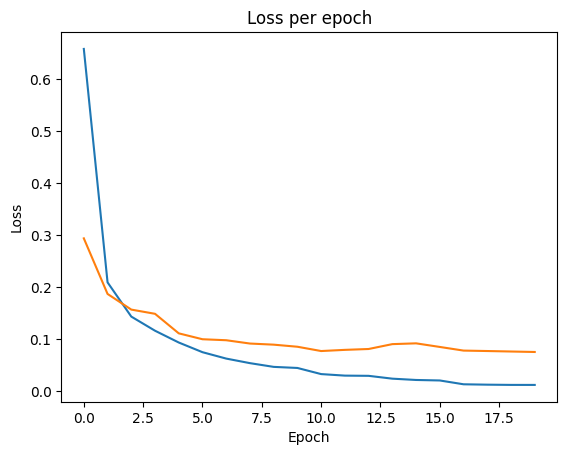

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

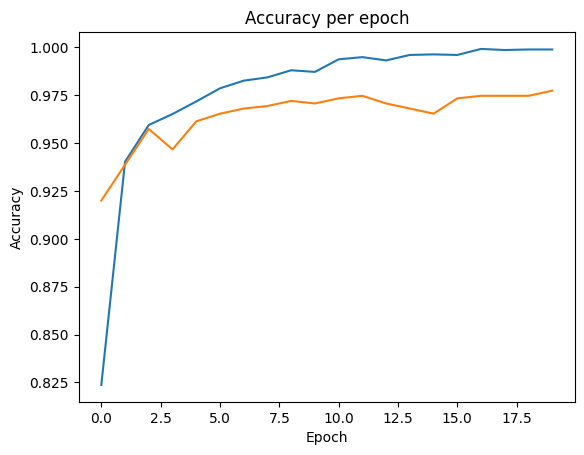

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### Xception

In [11]:
from keras.applications import Xception
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading model
xception_model = Xception(weights='imagenet', include_top=False, input_shape=(192, 192, 3))
feature_extractor = Model(inputs=xception_model.input, outputs=xception_model.get_layer('block14_sepconv2_act').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 192, 192,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 95, 95,    │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 95, 95,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 95, 95,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 93, 93,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 93, 93,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 93, 93,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 93, 93,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 93, 93,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 93, 93,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 93, 93,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 93, 93,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 47, 47,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 47, 47,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 47, 47,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 47, 47,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 47, 47,    │          0 │ add[0][0]       

 Total params: 22,964,781 (87.60 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=40,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.6926 - loss: 0.8798
Epoch 1: val_accuracy improved from -inf to 0.88933, saving model to model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 44s 298ms/step - accuracy: 0.6938 - loss: 0.8762 - val_accuracy: 0.8893 - val_loss: 0.3152 - learning_rate: 0.0010
Epoch 2/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9220 - loss: 0.2085
Epoch 2: val_accuracy improved from 0.88933 to 0.91333, saving model to model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9221 - loss: 0.2084 - val_accuracy: 0.9133 - val_loss: 0.2479 - learning_rate: 0.0010
Epoch 3/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9475 - loss: 0.1474
Epoch 3: val_accuracy improved from 0.91333 to 0.91600, saving model to model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9476 - loss: 0.1471 - val_accuracy: 0.9160 - val_loss: 0.2419 - learning_rate: 0.0010
Epoch 4/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9707 - l

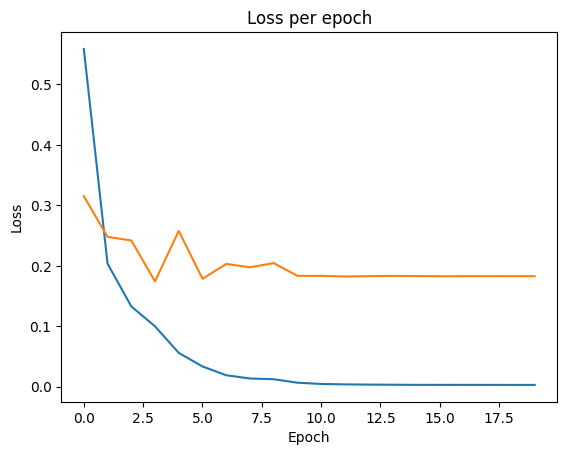

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

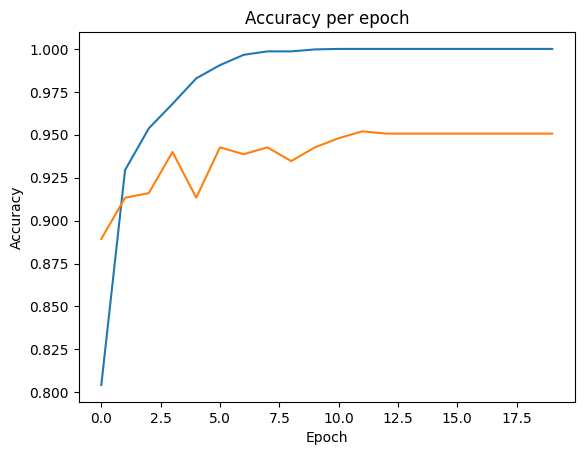

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### Inception

In [7]:
from keras.applications import InceptionV3
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading model
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(192, 192, 3))
feature_extractor = Model(inputs=inception_model.input, outputs=inception_model.get_layer('mixed10').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 192, 192,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 95, 95,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 95, 95,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 95, 95,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 93, 93,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 93, 93,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 93, 93,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 93, 93,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 93, 93,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 93, 93,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 46, 46,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 46, 46,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 46, 46,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 46, 46,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 44, 44,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 44, 44,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 44, 44,    │          0 │ batch_normalizat

 Total params: 23,906,085 (91.19 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=40,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
 3/88 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.2139 - loss: 3.4658  

I0000 00:00:1717924141.404631    2433 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.4311 - loss: 3.6799
Epoch 1: val_accuracy improved from -inf to 0.88133, saving model to model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 63s 437ms/step - accuracy: 0.4335 - loss: 3.6600 - val_accuracy: 0.8813 - val_loss: 0.3652 - learning_rate: 0.0010
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9014 - loss: 0.2920
Epoch 2: val_accuracy improved from 0.88133 to 0.91333, saving model to model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9014 - loss: 0.2920 - val_accuracy: 0.9133 - val_loss: 0.2575 - learning_rate: 0.0010
Epoch 3/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9162 - loss: 0.2349
Epoch 3: val_accuracy did not improve from 0.91333
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9162 - loss: 0.2348 - val_accuracy: 0.9080 - val_loss: 0.2783 - learning_rate: 0.0010
Epoch 4/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9394 - loss: 0.1723
Epoch 4: val_accuracy did not im

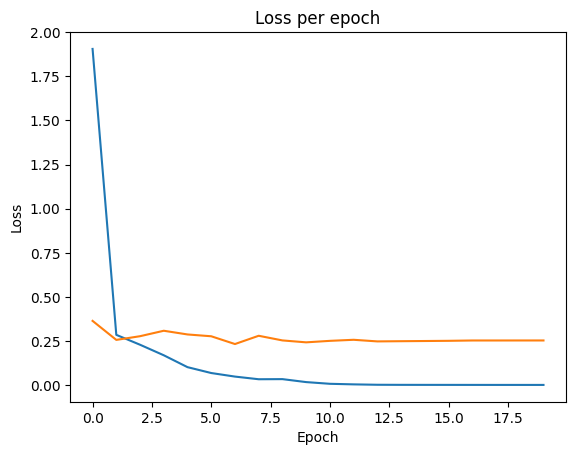

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

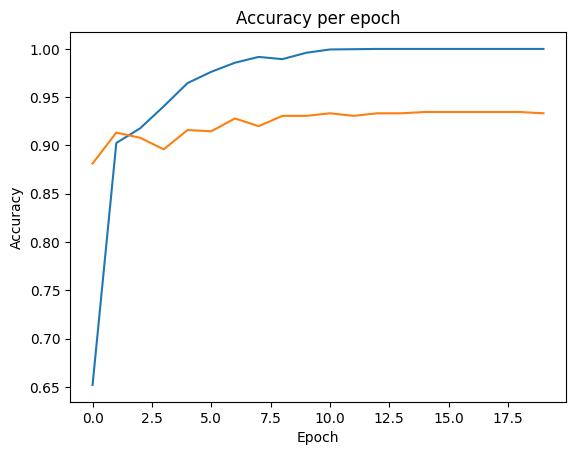

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### MobileNet

In [11]:
from keras.applications import MobileNet
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading MobileNet model
mobilenet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(192, 192, 3))
feature_extractor = Model(inputs=mobilenet_model.input, outputs=mobilenet_model.get_layer('conv_pw_13_relu').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

# Binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary()  # model summary


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 192, 192, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 96, 96, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 96, 96, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 96, 96, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 96, 96, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 96, 96, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 96, 96, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 97, 97, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 48, 48, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 48, 48, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 48, 48, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 48, 48, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,283,589 (16.34 MB)

 Trainable params: 1,054,725 (4.02 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=40,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
10/88 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2000 - loss: 2.4694

W0000 00:00:1717924250.558761    2434 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6468 - loss: 1.2208

W0000 00:00:1717924260.241061    2435 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.94667, saving model to model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 169ms/step - accuracy: 0.6489 - loss: 1.2137 - val_accuracy: 0.9467 - val_loss: 0.1622 - learning_rate: 0.0010
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9769 - loss: 0.0854
Epoch 2: val_accuracy improved from 0.94667 to 0.96267, saving model to model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9770 - loss: 0.0853 - val_accuracy: 0.9627 - val_loss: 0.1109 - learning_rate: 0.0010
Epoch 3/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9908 - loss: 0.0393
Epoch 3: val_accuracy improved from 0.96267 to 0.96533, saving model to model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9908 - loss: 0.0393 - val_accuracy: 0.9653 - val_loss: 0.1316 - learning_rate: 0.0010
Epoch 4/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9936 - loss: 0.0257
Epoch 4: val_accuracy did not improve from 0.96533
88/88 ━━━━━━━━━━━━━━━━

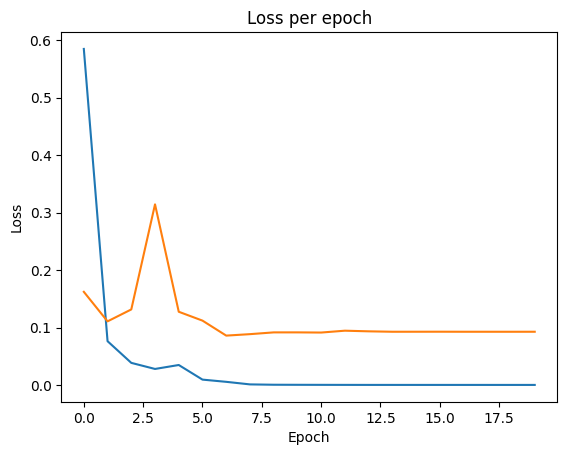

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

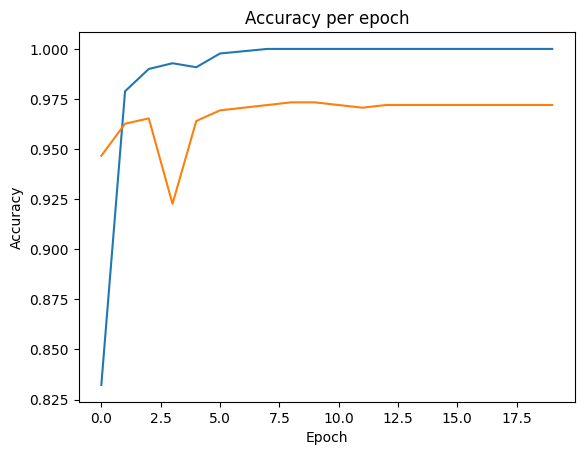

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### CNN

In [7]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, InputLayer
from keras.regularizers import l1_l2

model = Sequential()

model.add(InputLayer(shape=(192, 192, 3))) # input layer

# convolutional block
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

# convolutional block
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

# convolutional block
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

# convolutional block
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(GlobalAveragePooling2D()) # pooling down

model.add(Dense(1024, activation='relu')) # dense layer

model.add(Dense(5, activation='softmax')) # output layer

model.summary() # model summary

# model checkpoint callback
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 192, 192, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 192, 192, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 96, 96, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96, 96, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,285 (723.77 KB)

 Trainable params: 184,773 (721.77 KB)

 Non-trainable params: 512 (2.00 KB)

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=40,callbacks=[model_checkpoint])

Epoch 1/20


I0000 00:00:1717925237.686966    3494 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-06-09 09:27:28.372446: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{} for conv (f16[64,3,3,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[40,96,96,64]{3,2,1,0}, f16[40,96,96,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-09 09:27:28.918414: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.546089347s
Trying algorithm eng19{} for conv (f16[64,3,3,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[40,96,96,64]{3,2,1,0}, f16[40,96,96,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.5670 - loss: 1.0770
Epoch 1: val_accuracy improved from -inf to 0.13733, saving model to model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 37s 197ms/step - accuracy: 0.5683 - loss: 1.0745 - val_accuracy: 0.1373 - val_loss: 2.8789
Epoch 2/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8198 - loss: 0.5349
Epoch 2: val_accuracy improved from 0.13733 to 0.20933, saving model to model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8201 - loss: 0.5339 - val_accuracy: 0.2093 - val_loss: 5.0678
Epoch 3/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8734 - loss: 0.3650
Epoch 3: val_accuracy did not improve from 0.20933
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8733 - loss: 0.3655 - val_accuracy: 0.2000 - val_loss: 3.9797
Epoch 4/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8864 - loss: 0.3269
Epoch 4: val_accuracy improved from 0.20933 to 0.24533, saving model to model.keras
88/88 ━━━━━━━━━━━━━━

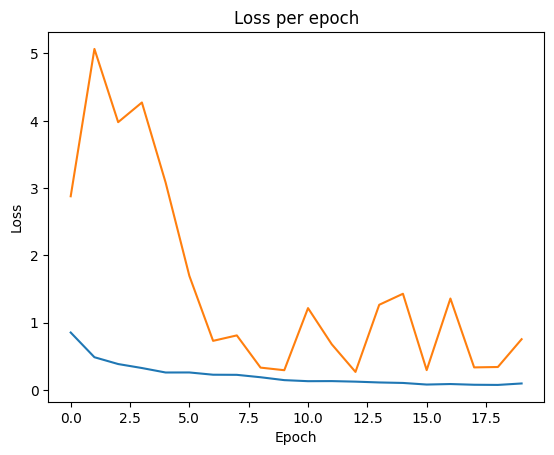

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

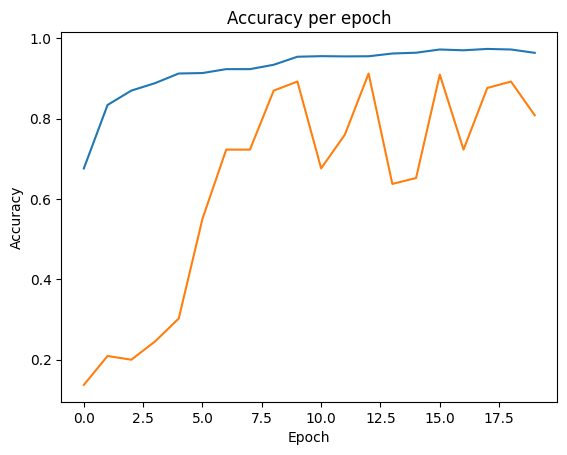

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()